# Context – Drunk Smurfs
Among all international hotel guests, Smurfs are burdened with the upkeep of a singular reputation: they are (supposedly) the rowdiest bunch one can entertain, and are equally well-known for unbridled spending as for racking up extensive costs in damages to hotel infrastructure, staff, and occasionally also other guests – costs which typically cannot be recovered once the guest has sought out the safety of his (or her) homeland.
It is your job as a data scientist to screen applying Smurfs clients for an exclusive hotel in the Bahamas - yes, it's the kind of hotel you need to apply for!
# The data
At your disposal is a training set containing data about the behavior of 5000 Smurf hotel guests (train_V2.csv). This data set contains information about the profit the hotel made during their last visit (excluding damages), but also whether they caused damages during their last visit, and for what amount. These outcomes are respectively called 'outcome_profit', 'outcome_damage_inc', and 'outcome_damage_amount'. To predict them, you have access to a host of personal information: previous history of profits and damages, use of hotel facilities, socio-demographics and behavioral scores from the staff of other hotels within the hotel chains. A minor description of features is available in dictionary.csv.
You also get information on the 500 applicants for the 2024 season (score.csv). It is your job to return a list of 150 clients that offer an attractive balance between projected profit for the hotel, and anticipated damages. 
You will notice the data set contains a large number of oddities. You are expected to think yourself about what is intuitive and acceptable in terms of approach, and to provide some minor reflection on this in your technical report. 


# Possible approach
To generate a client list, you can (but don't have to) follow the next steps:
1)	prepare the data set	
* briefly survey the data
* deal with data issues:
* appropriate handle categorical data
* treat missing data
* identify outliers, and choose whether to make your analysis more robust by removing these
2)	predict the projected revenue per clients
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
3)	predict which clients will cause damage
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
4)	for those that will wreak havoc, predict the amount of damage they will cause
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
5)	create a measure of the expected value of each applicant, and create an optimal selection of 200 guests


## 0. Loading packages and dataset

In [720]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-darkgrid')   

C:\Users\joery\AppData\Local\Temp\ipykernel_6924\1617307288.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [721]:
# read in data
train = pd.read_csv('train_V2.csv')
score = pd.read_csv('score.csv')
#dictionary = pd.read_csv('dictionary.csv')

## 1. Data exploration

1. and 2: number of features and observations

In [722]:
train.shape

(5000, 53)

In [723]:

# correlation matrix
corr_matrix = train.corr()
print(corr_matrix)
# Geen variabelen die een correlatie van 1 hebben dus op basis daarvan moeten we geen variabelen weglaten.


                       income_am  profit_last_am  profit_am  damage_am  \
income_am               1.000000        0.716032   0.685038   0.102339   
profit_last_am          0.716032        1.000000   0.424888   0.099840   
profit_am               0.685038        0.424888   1.000000   0.164160   
damage_am               0.102339        0.099840   0.164160   1.000000   
damage_inc              0.022713        0.046216   0.146981   0.622453   
crd_lim_rec             0.112643        0.058381   0.208033   0.288919   
credit_use_ic           0.043790        0.068244   0.114818   0.101889   
gluten_ic               0.158987        0.115330   0.167896   0.037240   
lactose_ic              0.287967        0.139112   0.404624   0.017174   
insurance_ic            0.006980        0.017561   0.058299   0.173917   
spa_ic                  0.000436        0.004509   0.038036   0.021302   
empl_ic                -0.018407       -0.008958  -0.016365   0.015352   
cab_requests            0.055035      

C:\Users\joery\AppData\Local\Temp\ipykernel_6924\449586712.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


# Check for constant variables

In [724]:
# There are no constant variables so we do not need to ommit any based on this information.
constant_columns = [col for col in train.columns if train[col].nunique() == 1]
print(constant_columns)


[]


In [725]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
income_am,4947.0,2281.260158,8365.254507,0.000000e+00,229.000000,469.000000,1688.000000,360577.000000
profit_last_am,4947.0,696.057712,3051.119275,0.000000e+00,0.000000,52.000000,810.000000,150537.000000
profit_am,4947.0,3637.900950,5726.625669,0.000000e+00,1638.000000,1889.000000,3165.500000,100577.000000
damage_am,4954.0,145.952967,581.068095,0.000000e+00,0.000000,0.000000,0.000000,14866.000000
damage_inc,4947.0,0.352335,0.889449,0.000000e+00,0.000000,0.000000,0.000000,10.000000
crd_lim_rec,4947.0,3298.716394,4549.646039,0.000000e+00,0.000000,1500.000000,5000.000000,30000.000000
credit_use_ic,4947.0,0.041237,0.198858,0.000000e+00,0.000000,0.000000,0.000000,1.000000
gluten_ic,4947.0,0.024661,0.155107,0.000000e+00,0.000000,0.000000,0.000000,1.000000
lactose_ic,4947.0,0.094199,0.292134,0.000000e+00,0.000000,0.000000,0.000000,1.000000
insurance_ic,4947.0,0.390944,0.488011,0.000000e+00,0.000000,0.000000,1.000000,1.000000


In [726]:
train[0:500].T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
income_am,227.0,268.0,283.0,227.0,4091.0,5108.0,13293.0,227.0,229.0,229.0,...,275.0,3655.0,227.0,3611.0,227.0,1564.0,1928.0,1010.0,1186.0,227.0
profit_last_am,0.0,16.0,23.0,0.0,1028.0,289.0,28.0,0.0,810.0,810.0,...,20.0,1441.0,0.0,1371.0,0.0,2656.5,20.0,243.0,403.0,0.0
profit_am,3201.0,1682.0,1673.0,1685.0,3425.0,6280.0,14704.0,1620.0,1620.0,1620.0,...,1630.0,2185.0,1620.0,2181.0,1620.0,5313.0,7426.0,1819.0,1771.0,1910.0
damage_am,888.0,0.0,0.0,0.0,785.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
damage_inc,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
crd_lim_rec,15000.0,750.0,750.0,0.0,14000.0,0.0,15000.0,0.0,0.0,0.0,...,0.0,0.0,15000.0,4000.0,0.0,0.0,0.0,7000.0,4500.0,4000.0
credit_use_ic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gluten_ic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lactose_ic,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insurance_ic,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


3. Check for datatypes

In [727]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  spor

4. and 5. Check for missing data

In [728]:
#Here we check how many missing values we have per variable.

train.isnull().sum()[train.isnull().sum() != 0]

income_am             53
profit_last_am        53
profit_am             53
damage_am             46
damage_inc            53
crd_lim_rec           53
credit_use_ic         53
gluten_ic             53
lactose_ic            53
insurance_ic          53
spa_ic                30
empl_ic                1
cab_requests          88
bar_no                53
sport_ic              53
neighbor_income      239
age                   53
marketing_permit      53
urban_ic              53
dining_ic             88
presidential          88
client_segment        53
sect_empl             53
prev_stay             53
prev_all_in_stay      53
divorce               53
fam_adult_size        53
children_no           53
tenure_mts           392
tenure_yrs           392
company_ic            53
claims_no             53
claims_am             27
nights_booked         53
gender                53
shop_am               53
shop_use              88
retired               53
gold_status           53
score1_pos          3775


In [729]:
#here we look at what percentage of the observations are not NaN per variable

(5000- train.isnull().sum()[train.isnull().sum() != 0])/5000*100

income_am           98.94
profit_last_am      98.94
profit_am           98.94
damage_am           99.08
damage_inc          98.94
crd_lim_rec         98.94
credit_use_ic       98.94
gluten_ic           98.94
lactose_ic          98.94
insurance_ic        98.94
spa_ic              99.40
empl_ic             99.98
cab_requests        98.24
bar_no              98.94
sport_ic            98.94
neighbor_income     95.22
age                 98.94
marketing_permit    98.94
urban_ic            98.94
dining_ic           98.24
presidential        98.24
client_segment      98.94
sect_empl           98.94
prev_stay           98.94
prev_all_in_stay    98.94
divorce             98.94
fam_adult_size      98.94
children_no         98.94
tenure_mts          92.16
tenure_yrs          92.16
company_ic          98.94
claims_no           98.94
claims_am           99.46
nights_booked       98.94
gender              98.94
shop_am             98.94
shop_use            98.24
retired             98.94
gold_status 

## b) Look at the data


In [730]:
#here we look at the first 16 variables
train.iloc[:,0:16].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0


In [731]:
#here we look at the variables starting from the 16th just to see what the data looks like
train.iloc[:,16:53].head()

,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


## Plot the data

<Axes: xlabel='count', ylabel='gender'>

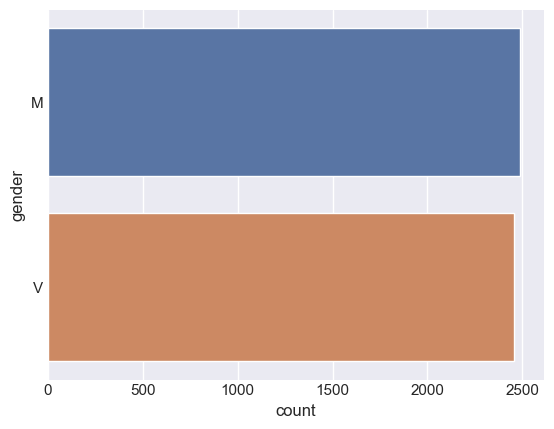

In [732]:
# Look at the amount of men and women with a bar chart
sns.countplot(y=train["gender"])

C:\Users\joery\AppData\Local\Temp\ipykernel_6924\2512075102.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.corr()


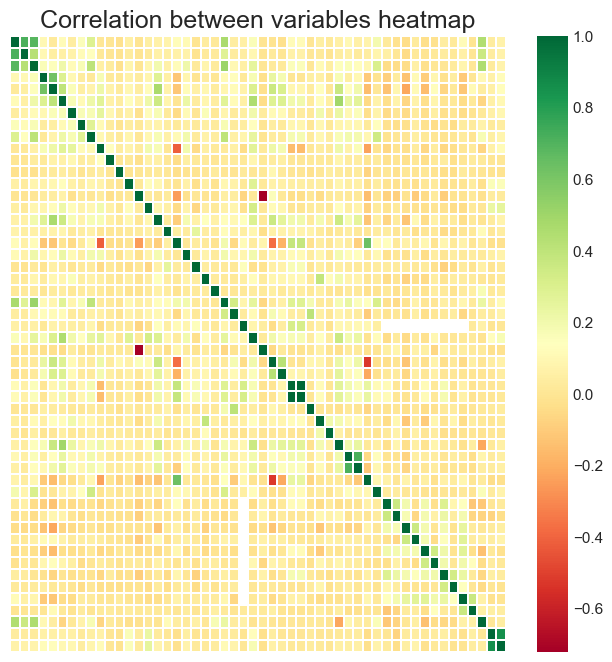

In [733]:
corrmat = train.corr()

fig, ax = plt.subplots(figsize=(8,8))

# Add title to the Heat map
title = "Correlation between variables heatmap"

# Set the font size and the distance of the title from the plot
plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

# Hide ticks for X & Y axis
ax.set_xticks([])
ax.set_yticks([])

# Remove the axes
ax.axis('off')

sns.heatmap(corrmat,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)

plt.show()


In [734]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_damage_inc"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[50:53]))

# plt.show()

In [735]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_profit"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[50:53]))

# plt.show()

In [736]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_damage_amount"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[50:53]))

# plt.show()

In [737]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_damage_amount'] - train['outcome_damage_amount'].mean()) / train['outcome_damage_amount'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_damage_amount"]))





92


In [738]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_profit'] - train['outcome_profit'].mean()) / train['outcome_profit'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_profit"]))

72


In [739]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_damage_inc'] - train['outcome_damage_inc'].mean()) / train['outcome_damage_inc'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_damage_inc"]))

0


## c) Look at the descriptives
1. For which features do you suspect outliers?
2. Which of these outliers seem most suspicious? Which would you certainly check if you were able to?

In [740]:
train.iloc[:,0:16].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0


2. Convert categorical

In [741]:
# Deze variabele is een boolean maar moet een getal worden

train['married_cd'] = train['married_cd'].astype('int')
train.loc[:, 'married_cd']

score['married_cd'] = score['married_cd'].astype('int')

## Clean the data

1. Drop duplicates

In [742]:
train = train.drop_duplicates()
train.head()



,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


2. Replace all NaN values with '-1'

In [743]:
# Replace all NaN values with a specified value (e.g., 0)
train.fillna(-1, inplace=True)
train.head()

score.fillna(-1, inplace=True)

In [744]:
na = train.isna()
columns_with_na = train.columns[na.any()].tolist() 
print(len(columns_with_na))

0


3. Drop irrelvant columns

gluten_ic and lactose_ic: The fact that a person is gluten or lactose intolerant does not indicate how likely it is for them to inflict damages or how much money they will be spending in the hotel. Maybe they will pay a tiny bit more for food without those ingredients but it shouldn't have a significant impact.

cab_requests: The hotel is very unlikely to own the cab company so wether or not they buy a lot of taxis will not influence the profit for the hotel.

marketing_permit: The choice on wether or not the marketing team may contact them will not influence how much money they will be spending nor how likely they are to inflict damages.

region: Although region could be a small factor due to cultural diferences in spending and personal traits, this could lead to discrimination of people of a certain region.

gender: Here it could also be that a cerain gender is for example more aggressive than others and thus more likely to inflict damages, but this could also lead to discrimination based on generalisations.

divorce: Being divorced or not does not impact the way you behave or spend money, definitely not if some time has passed. Maybe the first months they could be a bit more aggressive or impulsive due to their grief.

In [745]:



train = train.drop(['gluten_ic', 'lactose_ic', 'marketing_permit','divorce', 'cab_requests', 'urban_ic', 'gender', 'outcome_damage_amount', 'outcome_damage_inc'], axis=1)
score = score.drop(['gluten_ic', 'lactose_ic', 'marketing_permit', 'divorce', 'cab_requests', 'urban_ic', 'gender'], axis=1)



 I make sure all three categorical features are classified as 'object' to be able to check if they are categorical

4. Deal with unwanted outliers

No unwanted outliers found.

## Machine Learning 


Train the model to predict projected revenue


In [746]:
# # Dit algoritme heeft een score van 0.2842767456180185
# # Split the dataset into training and testing sets
# X = train
# y = train['outcome_profit']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Train a linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Evaluate the model on the testing set
# score = model.score(X_test, y_test)
# print('R^2 score on testing set:', score)

# # Predict the projected revenue for the 500 applicants

# # score = scaler.transform(score)
# # predictions = model.predict(score)

# # # Find the index of the client with the highest predicted profit
# # max_profit_index = predictions.argmax()

# # # Print the index and predicted profit of the client with the highest predicted profit
# # print(f"Client with index {max_profit_index} has the highest predicted profit of ${predictions[max_profit_index]:.2f}")


In [747]:
# Heeft een score van 0.025000182087153267
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

#TODO
# Split the dataset into training and testing sets
X = train
y = train['outcome_profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model using r-squared score
r2 = r2_score(y_test, y_pred)
print('R-squared score:', r2)

# Predict the projected revenue for the 500 applicants

# score = scaler.transform(score)
# predictions = model.predict(score)

# # Find the index of the client with the highest predicted profit
# max_profit_index = predictions.argmax()

# # Print the index and predicted profit of the client with the highest predicted profit
# print(f"Client with index {max_profit_index} has the highest predicted profit of ${predictions[max_profit_index]:.2f}")

R-squared score: 0.6123427600660949


In [748]:
# # Dit algoritme heeft een score van 0.5646249872330892
# from sklearn.tree import DecisionTreeRegressor

# # Split the dataset into training and testing sets
# X = train.drop(['outcome_profit'], axis=1)
# y = train['outcome_profit']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Create a decision tree regressor object
# dt_regressor = DecisionTreeRegressor(random_state=0)

# # Fit the regressor with the training data
# dt_regressor.fit(X_train, y_train)

# # Predict the revenue on the testing data
# y_pred_dt = dt_regressor.predict(X_test)

# # Compute R^2 score on the testing data
# r2_score_dt = dt_regressor.score(X_test, y_test)
# print("R^2 Score (Decision Tree Regression): ", r2_score_dt)


In [749]:
# # Dit algoritme heeft een score van 0.7581997911409797
# from sklearn.ensemble import RandomForestRegressor

# # Split the dataset into training and testing sets
# X = train.drop(['outcome_profit'], axis=1)
# y = train['outcome_profit']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Instantiate the model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)

# # Fit the model to the training data
# rf.fit(X_train, y_train)

# # Predict on the test data
# y_pred = rf.predict(X_test)

# # Evaluate the model using r2 score
# from sklearn.metrics import r2_score
# r2 = r2_score(y_test, y_pred)
# print("r2 score on test set:", r2)


In [750]:
# # Dit algoritme heeft een score van 0.771681378659433
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import r2_score

# # Split the dataset into training and testing sets
# X = train.drop(['outcome_profit'], axis=1)
# y = train['outcome_profit']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Instantiate the model
# model = GradientBoostingRegressor()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the testing data
# y_pred = model.predict(X_test)

# # Calculate the R-squared score on the testing data
# # r2 = r2_score(y_test, y_pred)
# # print("R-squared score on testing data:", r2)

# # Predict the projected revenue for the 500 applicants

# score = scaler.transform(score)
# predictions = model.predict(score)

# top_150_indices = np.argsort(predictions)[::-1][:150]
# top_150_incomes = predictions[top_150_indices]

# print("Top 150 incomes and their indices:")
# for i, income in zip(top_150_indices, top_150_incomes):
#     print(f"Index: {i}, Income: {income}")


# Damages

In [751]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Split the data into features (X) and target (y)
# X = train.drop(['profit_am', 'outcome_damage_amount', 'outcome_damage_inc'], axis=1)
# y = train['outcome_damage_inc'].notnull().astype(int)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the Random Forest Classifier model
# rf = RandomForestClassifier()

# # Define the hyperparameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Perform a grid search with 5-fold cross-validation
# rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
# rf_cv.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best Hyperparameters:", rf_cv.best_params_)
# print("Accuracy Score:", rf_cv.best_score_)


Score the 500 applicants

In [752]:

# # Use the trained Random Forest Classifier model to predict the outcome_damage_inc for the new data
# rf_pred = rf_cv.predict(score)

# # Append the predicted outcome_damage_inc to the new_data dataframe
# score['outcome_damage_inc'] = rf_pred.astype(bool)

# # Save the new_data dataframe with predicted outcome_damage_inc as a csv file
# score.to_csv('new_data_predicted_damage.csv', index=False)


# Predict damage amount